<a href="https://colab.research.google.com/github/semilem/ece3704/blob/main/kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

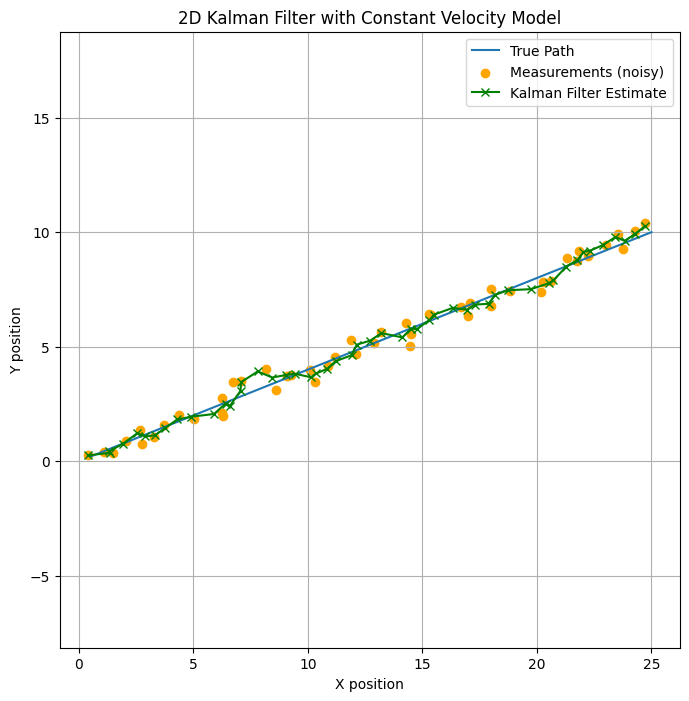

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Time step
dt = 1

# State transition matrix A
A = np.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Observation matrix H (we observe only positions)
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

# Process noise covariance Q
q = 0.01  # process noise strength
Q = q * np.array([
    [dt**4/4, 0, dt**3/2, 0],
    [0, dt**4/4, 0, dt**3/2],
    [dt**3/2, 0, dt**2, 0],
    [0, dt**3/2, 0, dt**2]
])

# Measurement noise covariance R
r = 0.1  # measurement noise strength
R = r * np.eye(2)

# Initial state estimate: start at (0,0) with (0,0) velocity
x_est = np.array([[0], [0], [0], [0]])

# Initial covariance matrix
P = np.eye(4)

# Simulate true trajectory
n_steps = 50
true_positions = []
true_velocities = []

# True motion: move diagonally with constant velocity
v_true = np.array([0.5, 0.2])  # true velocity (vx, vy)

pos = np.array([0, 0])

for _ in range(n_steps):
    pos = pos + v_true * dt
    true_positions.append(pos.copy())
    true_velocities.append(v_true.copy())

true_positions = np.array(true_positions)

# Simulate noisy measurements (only positions)
measurements = true_positions + np.random.normal(0, np.sqrt(r), size=true_positions.shape)

# For storing results
estimated_positions = []

for z in measurements:
    z = z.reshape(2,1)  # column vector

    # Predict
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q

    # Update
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(4) - K @ H) @ P_pred

    estimated_positions.append(x_est[:2].flatten())  # Only position part

estimated_positions = np.array(estimated_positions)

# Plotting
plt.figure(figsize=(8,8))
plt.plot(true_positions[:,0], true_positions[:,1], label='True Path')
plt.scatter(measurements[:,0], measurements[:,1], color='orange', label='Measurements (noisy)')
plt.plot(estimated_positions[:,0], estimated_positions[:,1], 'g-x', label='Kalman Filter Estimate')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('2D Kalman Filter with Constant Velocity Model')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

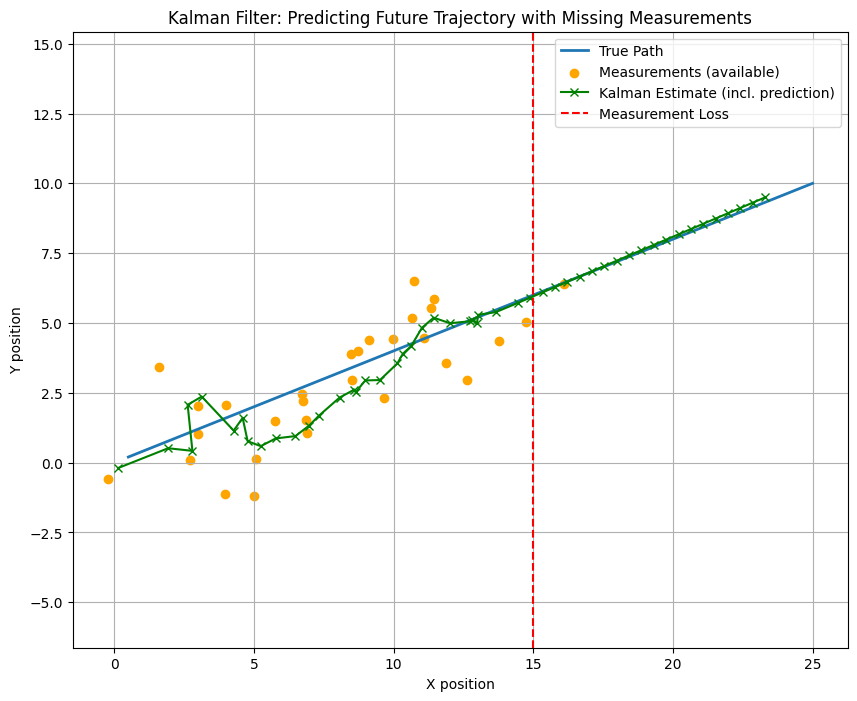

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Time step
dt = 1

# State transition matrix A
A = np.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Observation matrix H (observe only positions)
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

# Process noise covariance Q
q = 0.001
Q = q * np.array([
    [dt**4/4, 0, dt**3/2, 0],
    [0, dt**4/4, 0, dt**3/2],
    [dt**3/2, 0, dt**2, 0],
    [0, dt**3/2, 0, dt**2]
])

# Measurement noise covariance R
r = 2
R = r * np.eye(2)

# Initial state estimate
x_est = np.array([[0], [0], [0.5], [0.2]])  # Starting with correct velocity!
P = np.eye(4)

# Simulate true trajectory
n_steps = 50
true_positions = []
v_true = np.array([0.5, 0.2])  # constant velocity
pos = np.array([0, 0])

for _ in range(n_steps):
    pos = pos + v_true * dt
    true_positions.append(pos.copy())

true_positions = np.array(true_positions)

# Simulate measurements (only for the first 30 steps)
measurements = true_positions.copy()
measurements[:30] += np.random.normal(0, np.sqrt(r), size=(30,2))
measurements[30:] = np.nan  # no measurements after step 30

# Store results
estimated_positions = []

for i in range(n_steps):
    # Predict
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q

    if not np.isnan(measurements[i,0]):
        # Measurement available
        z = measurements[i].reshape(2,1)

        # Update
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
        x_est = x_pred + K @ (z - H @ x_pred)
        P = (np.eye(4) - K @ H) @ P_pred
    else:
        # No measurement, use prediction only
        x_est = x_pred
        P = P_pred

    estimated_positions.append(x_est[:2].flatten())

estimated_positions = np.array(estimated_positions)

# Plotting
plt.figure(figsize=(10,8))
plt.plot(true_positions[:,0], true_positions[:,1], label='True Path', linewidth=2)
plt.scatter(measurements[:30,0], measurements[:30,1], color='orange', label='Measurements (available)')
plt.plot(estimated_positions[:,0], estimated_positions[:,1], 'g-x', label='Kalman Estimate (incl. prediction)')
plt.axvline(x=30*v_true[0], color='red', linestyle='--', label='Measurement Loss')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Kalman Filter: Predicting Future Trajectory with Missing Measurements')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

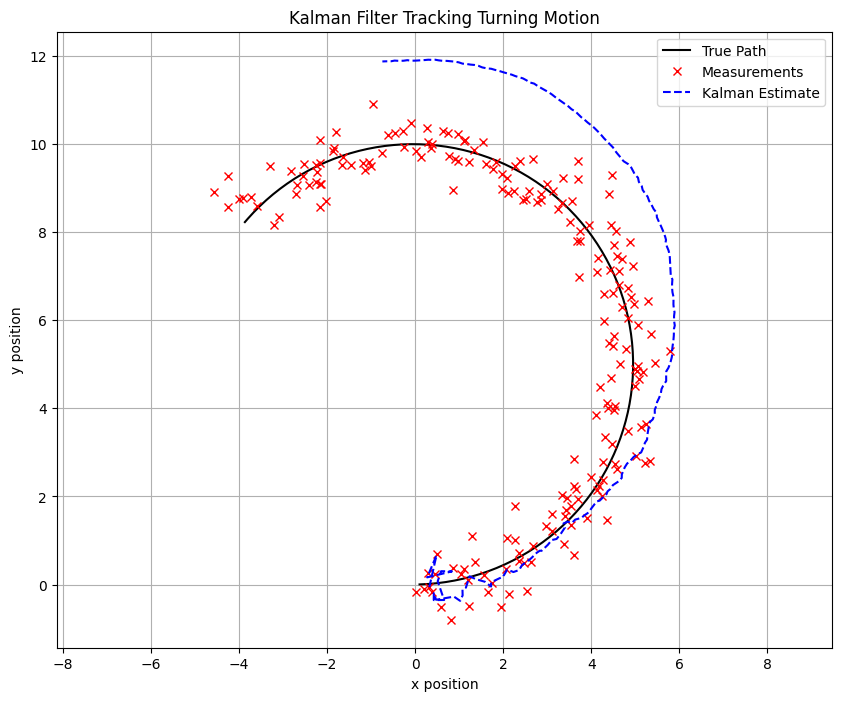

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
dt = 0.1       # time step
T = 20         # total time (seconds)
steps = int(T/dt)
np.random.seed(42)  # for reproducibility

# True motion parameters
v = 1.0        # constant speed
omega = 0.2    # constant angular velocity (radians/second)

# Allocate arrays
true_states = []
measurements = []
kalman_estimates = []

# Initial true state: [x, y, vx, vy]
x_true = np.array([0, 0, v, 0])

# Kalman filter initial setup
x_est = np.array([0, 0, 0, 0])  # initial guess
P = np.eye(4) * 500             # large initial uncertainty

F = np.array([
    [1, 0, dt, 0],
    [0, 1, 0, dt],
    [0, 0, 1,  0],
    [0, 0, 0,  1]
])  # motion model (constant velocity)

H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])  # we observe only position

R = np.eye(2) *0.2# measurement noise covariance (position noise)

# Process noise covariance (small acceleration noise)
sigma_a = 0.001
Q = sigma_a**2 * np.array([
    [dt**4/4, 0, dt**3/2, 0],
    [0, dt**4/4, 0, dt**3/2],
    [dt**3/2, 0, dt**2, 0],
    [0, dt**3/2, 0, dt**2]
])

for step in range(steps):
    # === Simulate true motion (turning) ===
    theta = omega * dt
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    # Rotate velocity vector
    vx, vy = x_true[2], x_true[3]
    v_new = np.array([
        cos_theta * vx - sin_theta * vy,
        sin_theta * vx + cos_theta * vy
    ])
    x_true[2], x_true[3] = v_new

    # Update position
    x_true[0] += x_true[2] * dt
    x_true[1] += x_true[3] * dt

    # Save true state
    true_states.append(x_true.copy())

    # === Simulate measurement (noisy observation) ===
    z = x_true[:2] + np.random.randn(2) * np.sqrt(R[0,0])
    measurements.append(z)

    # === Kalman Filter: Predict ===
    x_est = F @ x_est
    P = F @ P @ F.T + Q

    # === Kalman Filter: Update ===
    y = z - (H @ x_est)                    # innovation
    S = H @ P @ H.T + R                    # innovation covariance
    K = P @ H.T @ np.linalg.inv(S)          # Kalman gain

    x_est = x_est + K @ y
    P = (np.eye(4) - K @ H) @ P

    kalman_estimates.append(x_est.copy())

# Convert lists to arrays
true_states = np.array(true_states)
measurements = np.array(measurements)
kalman_estimates = np.array(kalman_estimates)

# === Plotting ===
plt.figure(figsize=(10, 8))
plt.plot(true_states[:, 0], true_states[:, 1], 'k-', label='True Path')
plt.plot(measurements[:, 0], measurements[:, 1], 'rx', label='Measurements')
plt.plot(kalman_estimates[:, 0], kalman_estimates[:, 1], 'b--', label='Kalman Estimate')
plt.legend()
plt.title('Kalman Filter Tracking Turning Motion')
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(True)
plt.axis('equal')
plt.show()

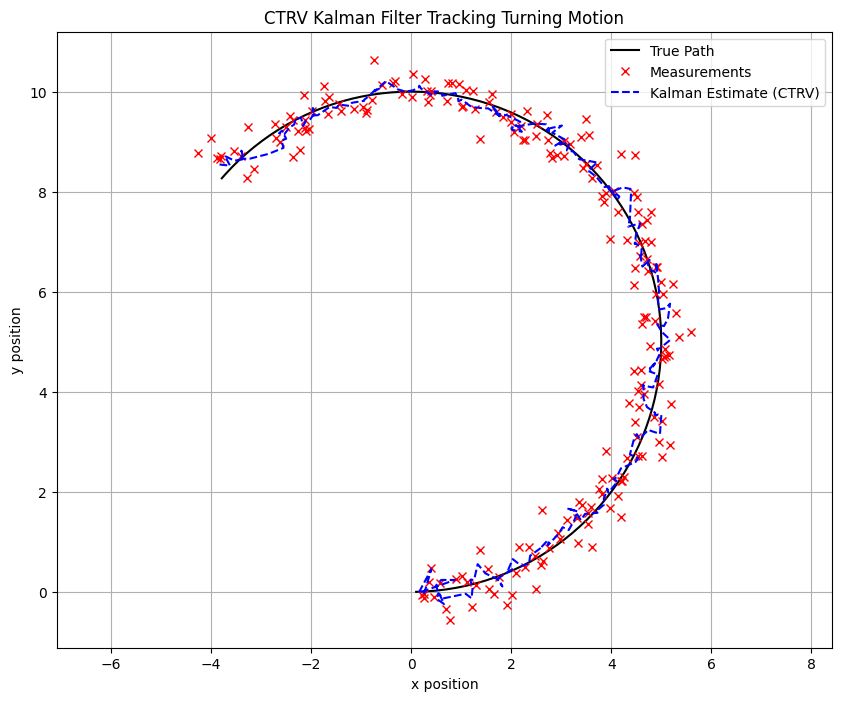

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
dt = 0.1
T = 20
steps = int(T / dt)
np.random.seed(42)

# True motion parameters
v_true = 1.0        # constant speed
omega_true = 0.2    # constant turn rate (rad/s)

# Allocate arrays
true_states = []
measurements = []
kalman_estimates = []

# Initial true state: [x, y, v, heading, turn rate]
x_true = np.array([0, 0, v_true, 0, omega_true])

# Kalman filter initial guess
x_est = np.array([0, 0, 0.5, 0, 0.1])  # not exactly correct initially
P = np.eye(5) * 500

# Measurement matrix: we only observe x, y
H = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0]
])
R = np.eye(2) * 0.1  # measurement noise

# Process noise (small acceleration and turn rate noise)
Q = 0.1*np.diag([0.1, 0.1, 0.1, 0.01, 0.01])

for step in range(steps):
    # === Simulate true motion (CTRV) ===
    x, y, v, psi, omega = x_true

    if abs(omega) > 1e-4:
        x += (v / omega) * (np.sin(psi + omega * dt) - np.sin(psi))
        y += (v / omega) * (-np.cos(psi + omega * dt) + np.cos(psi))
    else:
        x += v * np.cos(psi) * dt
        y += v * np.sin(psi) * dt

    psi += omega * dt

    x_true = np.array([x, y, v, psi, omega])
    true_states.append(x_true.copy())

    # === Simulate measurement ===
    z = x_true[:2] + np.random.randn(2) * np.sqrt(R[0,0])
    measurements.append(z)

    # === Kalman Filter Predict ===
    # Build Jacobian F dynamically (linearization)
    _, _, v_est, psi_est, omega_est = x_est
    if abs(omega_est) > 1e-4:
        F = np.array([
            [1, 0, (np.sin(psi_est + omega_est * dt) - np.sin(psi_est)) / omega_est,
             (v_est * (np.cos(psi_est + omega_est * dt) - np.cos(psi_est))) / omega_est,
             (v_est * (np.cos(psi_est) * omega_est * dt - np.cos(psi_est + omega_est * dt) * omega_est * dt +
              np.sin(psi_est + omega_est * dt) - np.sin(psi_est))) / (omega_est**2)],
            [0, 1, (-np.cos(psi_est + omega_est * dt) + np.cos(psi_est)) / omega_est,
             (v_est * (np.sin(psi_est + omega_est * dt) - np.sin(psi_est))) / omega_est,
             (v_est * (np.sin(psi_est) * omega_est * dt - np.sin(psi_est + omega_est * dt) * omega_est * dt +
              np.cos(psi_est + omega_est * dt) - np.cos(psi_est))) / (omega_est**2)],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, dt],
            [0, 0, 0, 0, 1]
        ])
    else:
        F = np.array([
            [1, 0, np.cos(psi_est) * dt, -v_est * np.sin(psi_est) * dt, 0],
            [0, 1, np.sin(psi_est) * dt,  v_est * np.cos(psi_est) * dt, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, dt],
            [0, 0, 0, 0, 1]
        ])

    # Predict state
    x, y, v, psi, omega = x_est
    if abs(omega) > 1e-4:
        x += (v / omega) * (np.sin(psi + omega * dt) - np.sin(psi))
        y += (v / omega) * (-np.cos(psi + omega * dt) + np.cos(psi))
    else:
        x += v * np.cos(psi) * dt
        y += v * np.sin(psi) * dt

    psi += omega * dt

    x_est = np.array([x, y, v, psi, omega])

    # Predict covariance
    P = F @ P @ F.T + Q

    # === Kalman Filter Update ===
    y = z - (H @ x_est)
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)

    x_est = x_est + K @ y
    P = (np.eye(5) - K @ H) @ P

    kalman_estimates.append(x_est.copy())

# Convert lists to arrays
true_states = np.array(true_states)
measurements = np.array(measurements)
kalman_estimates = np.array(kalman_estimates)

# === Plotting ===
plt.figure(figsize=(10, 8))
plt.plot(true_states[:, 0], true_states[:, 1], 'k-', label='True Path')
plt.plot(measurements[:, 0], measurements[:, 1], 'rx', label='Measurements')
plt.plot(kalman_estimates[:, 0], kalman_estimates[:, 1], 'b--', label='Kalman Estimate (CTRV)')
plt.legend()
plt.title('CTRV Kalman Filter Tracking Turning Motion')
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(True)
plt.axis('equal')
plt.show()